In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
import pylab
import scipy
import sklearn
import time
import seaborn as sns
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

%matplotlib inline
from IPython.display import display
from notebook.services.config import ConfigManager


# Comparison of blood stem cell biology in young and old mice using unsupervised learning approaches

## What is a blood (hematopoietic) stem cell (HSC)?


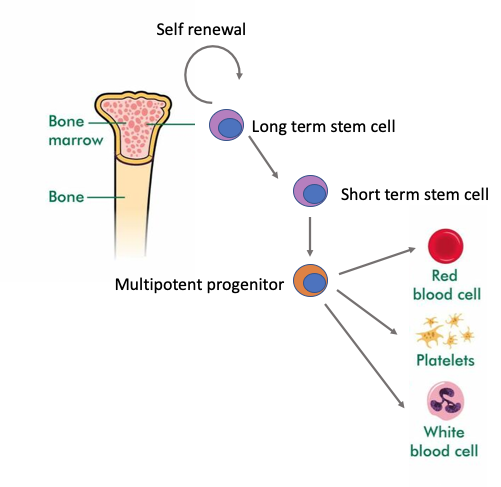
adapted from © Macmillan Cancer Support 2020

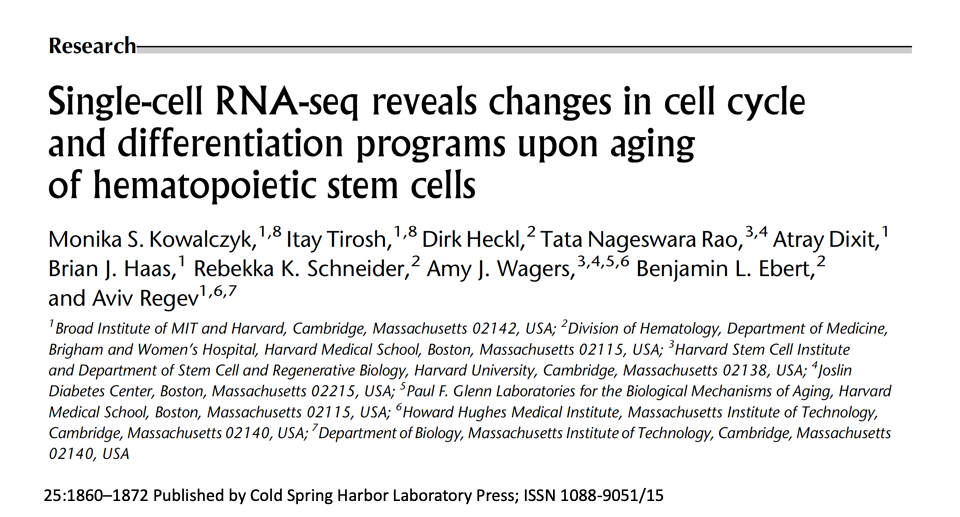

## Methods
### Step 1: Isolation of stem cells:
flush out bone marrow from ~10 old mice ~10 young mice





## Methods
### Step 2: Sort cells of interest: long term stem cells, shorterm stem cells, multipotent blood cells

Use partiticular gene products (Itgam, Ly6g, Ptprc, Cd3e, Ly76, Kit, Ly6a, Cd48, Slamf1) to distiguish cell types  and collect them by flourescence assisted cell sorting  (FACS)





Sorting yielded ~ 200 per cell type:

    1. Long term HSC--young
    2. Long term HSC--old

    3. Short term HSC--young
    4. Short term HSC--old

    5. Multipotent--young
    6. Multipotent--old

~1200 cells (samples)

## Methods
### Step 3: Analyze individual cell gene programs

Use method called single cell RNA-seq to get genetic composition of all sorted cells

RNA-seq yielded ~8000 genes analyzed (dimensions) per cell with respective quantity of each gene given as output

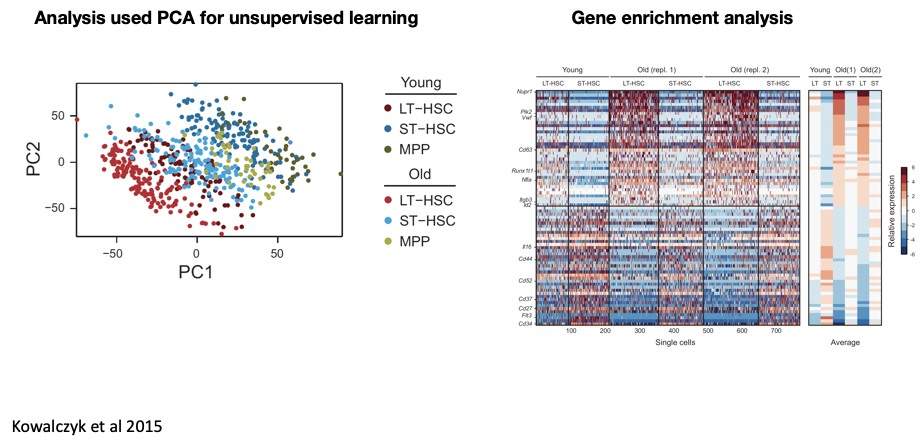

## Conclusions
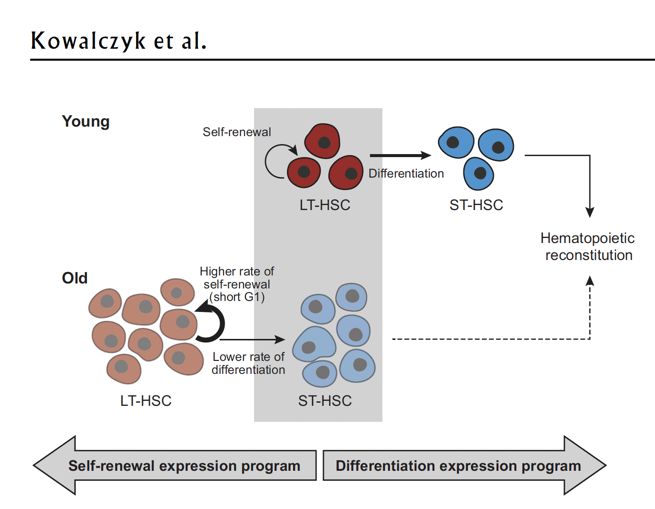

## Project goal:
### Take this dataset and apply more unsupervised learning methods to uncover patterns in early blood development

This is an important area of research since these investigations are still nascent

Understanding stem cell biology, especially during transition states can reveal new ways to improve health of stem cells for correcting blood disease such as leukemia and possibly autoimmune disorders

## Strategy:

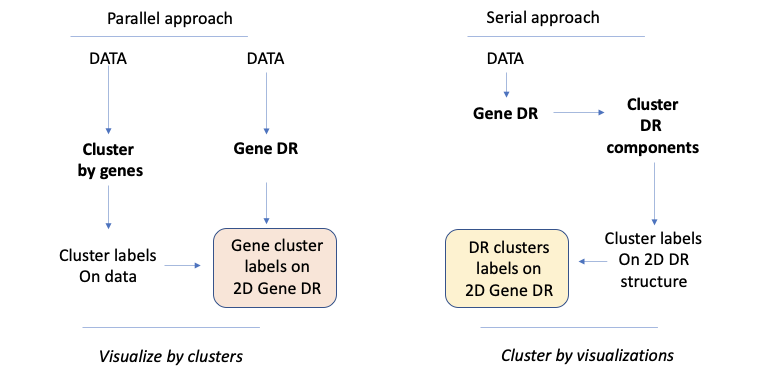


In [338]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)


## Data cleaning steps

In [44]:
#Raw dataset
df.head(4)

Gene Symbol                                   UCSC transcripts  \
0       'Npl'                                       'uc007dac.1'   
1        'Qk'      'uc008akb.2,uc008akc.2,uc008ake.2,uc012ajv.1'   
2     'Park2'  'uc008akj.1,uc008akk.1,uc012ajy.1,uc012ajz.1,u...   
3    'Agpat4'                                       'uc008akm.1'   

   young_LT_HSC_2  young_LT_HSC_6  young_LT_HSC_8  young_LT_HSC_9  \
0        0.000000             0.0        0.000000             0.0   
1        0.000000             0.0        0.000000             0.0   
2        2.666757             0.0        6.331813             0.0   
3        0.000000             0.0        0.000000             0.0   

   young_LT_HSC_10  young_LT_HSC_11  young_LT_HSC_12  young_LT_HSC_14  ...  \
0         0.000000         0.000000         0.000000         0.000000  ...   
1         0.000000         0.000000         6.090007         0.000000  ...   
2         0.000000         4.964399         0.000000         8.015638  ...   
3         2.157044         0.000000         7.248876         4.364572  ...   

   old_ST_HSC_biol_replicate_189  old_ST_HSC_biol_replicate_190  \
0                       0.000000                       0.000000   
1                       1.090853                       0.000000   
2                       0.000000                       2.060047   
3                       0.201634                       0.000000   

   old_ST_HSC_biol_replicate_191  old_ST_HSC_biol_replicate_192  \
0                       7.157751                       0.000000   
1                       0.000000                       0.536053   
2                       1.726831                       4.643856   
3                       0.000000                       1.238787   

   'Young LT-HSC'  'Young ST-HSC'  'Young MPP'  'Old LT-HSC'  'Old ST-HSC'  \
0        6.099788        6.377873     6.153996      5.860976      6.106499   
1        3.390214        4.126645     3.706174      3.491723      3.557641   
2        2.209713        1.945978     1.691467      3.127523      1.833349   
3        5.390465        4.474588     3.271644      5.192353      4.338350   

   Old MPP'  
0  6.138063  
1  3.224304  
2  1.453907  
3  3.432678  

[4 rows x 1436 columns]

In [81]:
#Transpose features and samples; drop useless columns and get rid of extra quotes from gene names
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

In [83]:
#Relabel index names to have cell type names as group labels
import re
df1_1 = df1[~df1.index.str.contains('biol_replicate')]
df1_1 = df1_1.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])

# Need to remove the gene features used to isolate the cell types to reduce biase in analysis
df1_1 = df1_1.drop(['Itgam', 'Ptprc', 'Kit', 'Ly6a', 'Cd48', 'Slamf1'], axis = 1)

In [84]:
#Final clean up step of cell type label names
df1_1.index = df1_1.index.str.replace(r'[^a-zA-Z]', '')

print((df1_1.columns).shape)
print(np.unique(df1_1.index))

(8416,)
['oldLTHSC' 'oldMPP' 'oldSTHSC' 'youngLTHSC' 'youngMPP' 'youngSTHSC']


### Deal with gene duplicates

In [48]:
#Get individual names for genes that are duplicated
dupcols = np.unique(df1_1dup.columns)
dupcols

array(['Abcg2', 'Arih1', 'Atf7ip', 'Atrip', 'Brwd1', 'Cbx1', 'Ccnd3',
       'Cdk6', 'Celf1', 'Commd1', 'Csnk1a1', 'Ctse', 'Dnajb6', 'Eci2',
       'Eif1ax', 'Fgd4', 'Fus', 'G3bp1', 'Glod4', 'Gm10598', 'Gm13215',
       'Hjurp', 'Ikbkb', 'Ing4', 'Itga4', 'Itga6', 'Kansl2', 'Lcor',
       'Lrrc29', 'Luc7l2', 'Mafg', 'Mecom', 'Mob1a', 'Mtcp1', 'Nagk',
       'Ndufa3', 'Pafah1b1', 'Patz1', 'Pcif1', 'Pik3ip1', 'Psme4', 'Pten',
       'Ramp2', 'Rpl24', 'Rspry1', 'Satb1', 'Smarcc2', 'Srcap', 'Srsf10',
       'Sugp2', 'Taf9', 'Tex261', 'Tmem167b', 'Tmem181b-ps', 'Trappc9',
       'Trim30b', 'U2af1l4', 'Utp23', 'Wwp2', 'Zbtb20', 'Zfp708',
       'Zfp869', 'Zgpat'], dtype=object)

In [49]:
#Place into separate dataframe for processing
df1_1dup = df1_1[df1_1.loc[:,df1_1.columns.duplicated()].columns]
df1_1dup.head(1)

Ccnd3   Ccnd3 Satb1 Satb1  Csnk1a1 Csnk1a1 Csnk1a1  Csnk1a1  \
youngLTHSC  8.05376  9.6887     0     0  8.53974       0       0  8.53974   

           Csnk1a1 Csnk1a1  ...    Rpl24    Rpl24 Brwd1 Brwd1 Brwd1 Brwd1  \
youngLTHSC       0       0  ...  9.32535  7.56491     0     0     0     0   

           Brwd1 Brwd1 Tmem181b-ps Tmem181b-ps  
youngLTHSC     0     0     8.00225           0  

[1 rows x 134 columns]

In [50]:
#Sum duplicate gene values
df1_1dupgroup = df1_1dup.groupby(df1_1dup.columns, axis=1).sum()

#Average duplicate gene values
df1_1dupmean = pd.DataFrame()
for x in dupcols:
    df1_1dupmean[x] = df1_1dupgroup[x]/df1_1dup.columns.tolist().count(x)
    
df1_1dupmean.head(1)

Abcg2  Arih1  Atf7ip  Atrip  Brwd1      Cbx1     Ccnd3  \
youngLTHSC  7.164359    0.0     0.0    0.0    0.0  3.493262  8.871234   

                Cdk6  Celf1  Commd1  ...  Tmem181b-ps   Trappc9   Trim30b  \
youngLTHSC  1.656623    0.0     0.0  ...     4.001126  4.490826  3.274372   

            U2af1l4    Utp23  Wwp2    Zbtb20    Zfp708    Zfp869  Zgpat  
youngLTHSC      0.0  2.07528   0.0  4.221865  1.596097  4.296434    0.0  

[1 rows x 63 columns]

In [51]:
#Replace duplicated gene columns with single averaged gene columns
dfnodup = df1_1.loc[:,~df1_1.columns.duplicated()].drop(dupcols, axis = 1)

df2 = pd.concat([dfnodup, df1_1dupmean], axis = 1)

df2= df2.astype(np.float64).round(2)


## Feature engineering steps

In [52]:
df2.head(5)

Npl   Qk  Park2  Agpat4  Slc22a3  uc008akv.1  Airn  Mrpl18   Tcp1  \
youngLTHSC  0.0  0.0   2.67    0.00     0.00         0.0  0.00    9.26   0.00   
youngLTHSC  0.0  0.0   0.00    0.00     0.00         0.0  0.00    0.00  10.51   
youngLTHSC  0.0  0.0   6.33    0.00     0.00         0.0  3.94    0.00   0.00   
youngLTHSC  0.0  0.0   0.00    0.00     0.00         0.0  0.00    8.80   0.00   
youngLTHSC  0.0  0.0   0.00    2.16     6.61         0.0  0.00    8.84   6.12   

            Rnasel  ...  Tmem181b-ps  Trappc9  Trim30b  U2af1l4  Utp23  Wwp2  \
youngLTHSC    0.00  ...         4.00     4.49     3.27     0.00   2.08  0.00   
youngLTHSC    3.63  ...         4.60     1.60     0.00     0.00   1.75  1.03   
youngLTHSC    7.18  ...         4.83     3.56     0.72     0.00   0.95  0.00   
youngLTHSC    0.00  ...         4.02     2.00     0.66     5.35   1.81  3.90   
youngLTHSC    8.17  ...         3.71     4.07     0.00     7.58   2.19  0.00   

            Zbtb20  Zfp708  Zfp869  Zgpat  
youngLTHSC    4.22     1.6    4.30    0.0  
youngLTHSC    3.12     0.0    7.91    0.0  
youngLTHSC    4.10     0.0    0.00    0.0  
youngLTHSC    0.96     0.0    0.00    0.0  
youngLTHSC    0.00     4.2    0.00    0.0  

[5 rows x 8351 columns]

### This data set has a zero inflation problem:
"Dimensionality reduction of such high-dimensional data sets is essential for visualization and analysis, but single-cell RNA-seq data are challenging for classical dimensionalityreduction methods because of the prevalence of dropout events, which lead to zero-inflated data."

In [53]:
%%capture out

plt.hist(df2['Flt3'])
plt.title('Gene: Flt3')
plt.ylabel('Frequency (counts)')
plt.xlabel('Gene expression value')
plt.show()

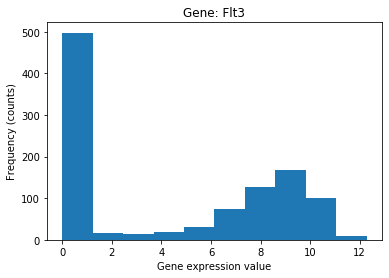

In [54]:
display(out.outputs[0])

### Deal with "zero inflation" of data:

#### High spike in zero values represents both real zeros ( zeroness) and dropout events (missingness): 
Based on the current understanding of the single cell analysis technical limits, we will assume they are dropouts


1. Can reduce number of genes with fewer than certain level of dropouts

2. Use a newer technique call zero-inflation factor analysis

### Reduce number of genes with fewer than certain level of dropouts

In [55]:
genefracs = (df2==0).sum()/(df2==0).count() # make list of genes with corresponding fraction of drop outs

# Sublist genes with selected fractions
passindex20 = genefracs[genefracs < 0.20] 
passindex40 = genefracs[genefracs < 0.40]
passindex95 = genefracs[genefracs < 0.95]

# make separate dataframes that contains genes with selected fractions of drop outs
df2_p20 = df2[passindex20.index]
df2_p40 = df2[passindex40.index]
df2_p95 = df2[passindex95.index]

In [85]:
print(f"Number of genes with fewer than 95% dropouts is {df2_p95.shape[1]}")
print(f"Number of genes with fewer than 40% dropouts is {df2_p40.shape[1]}")
print(f"Number of genes with fewer than 20% dropouts is {df2_p20.shape[1]}")



Number of genes with fewer than 95% dropouts is 8240
Number of genes with fewer than 40% dropouts is 2114
Number of genes with fewer than 20% dropouts is 1052


## PCA dimension reduction

In [118]:
# Run PCA on datasets with noted fractions of drop out cutoffs
pca95 = PCA(n_components = 10)
pcafit95 = pca95.fit_transform(df2_p95)

pca40 = PCA(n_components = 10)
pcafit40 = pca40.fit_transform(df2_p40)

pca20 = PCA(n_components = 10)
pcafit20 = pca20.fit_transform(df2_p20)

In [385]:
%%capture out
# Plot PCA data 
fig = plt.figure(figsize = (15,5))
fig.subplots_adjust(hspace=1, wspace=.2)

plt.subplot(1,3,1)
sns.scatterplot(pcafit95[:,0], pcafit95[:,1]), #hue = df2.index, legend = False)
plt.title('PCA: \n genes < 95% dropouts', size = 15)
plt.xlabel('PC2')
plt.ylabel('PC1')

plt.subplot(1,3,2)
sns.scatterplot(pcafit40[:,0], pcafit40[:,1])#, hue = df2.index, legend = False)
plt.title('PCA: \n genes <40% dropouts', size = 15)
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.subplot(1,3,3)
sns.scatterplot(pcafit20[:,0], pcafit20[:,1])#, hue = df2.index)
plt.title('PCA: \n < genes 20% dropouts', size = 15)
plt.xlabel('PC2')
plt.ylabel('PC1')
# #plt.legend(loc='center left', bbox_to_anchor=(1, .5),fontsize=10, 
#            frameon = True, facecolor = 'white', framealpha=1, edgecolor = 'white')


plt.show()

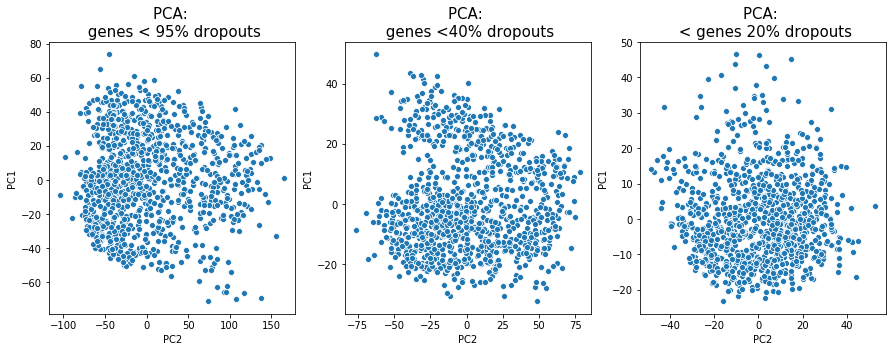

In [386]:
display(out.outputs[0])

In [121]:
%%capture out
# Plot explained variance per component for each PCA above
variance95 = np.insert(pca95.explained_variance_ratio_, 0, 1)
variance40 = np.insert(pca40.explained_variance_ratio_, 0, 1)
variance20 = np.insert(pca20.explained_variance_ratio_, 0, 1)

x95 = [i for i in range(variance95.shape[0])]
x40 = [i for i in range(variance40.shape[0])]
x20 = [i for i in range(variance20.shape[0])]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(x95, variance95)
plt.title('Fewer than 95% dropouts')
plt.xlabel('pca components')
plt.ylabel('Variance explained ratio')
plt.subplot(132)
plt.plot(x40, variance40)
plt.title('Fewer than 40% dropouts')
plt.xlabel('pca components')

plt.subplot(133)
plt.plot(x20, variance20)
plt.title('Fewer than 20% dropouts')
plt.xlabel('pca components')

plt.show()

## PCA Explained Variance

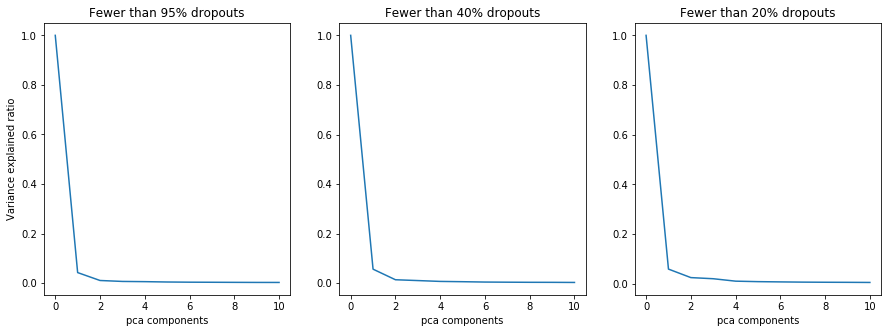

In [122]:
display(out.outputs[0])

In [66]:
# Apply dimension reduction on datasets with various dropout cutoffs
umap_results95 = umap.UMAP(n_neighbors=20,
                      min_dist=.1,
                      metric='euclidean').fit_transform(df2_p95)
umap_results40 = umap.UMAP(n_neighbors=20,
                      min_dist=.1,
                      metric='euclidean').fit_transform(df2_p40)
umap_results20 = umap.UMAP(n_neighbors=20,
                      min_dist=.1,
                      metric='euclidean').fit_transform(df2_p20)

In [387]:
%%capture out
# Visualize UMAP reduced data
fig = plt.figure(figsize = (15,5))
fig.subplots_adjust(hspace=1, wspace=.2)

plt.subplot(1,3,1)
sns.scatterplot(umap_results95[:,0], umap_results95[:,1])#, hue = df2.index, legend = False)
plt.title('UMAP: \n genes < 95% dropouts', size = 15)


plt.subplot(1,3,2)
sns.scatterplot(umap_results40[:,0], umap_results40[:,1])#, hue = df2.index, legend = False)
plt.title('UMAP: \n genes < 40% dropouts', size = 15)

plt.subplot(1,3,3)
sns.scatterplot(umap_results20[:,0], umap_results20[:,1])#, hue = df2.index)
plt.title('UMAP: \n genes < 20% dropouts', size = 15)
# #plt.legend(loc='center left', bbox_to_anchor=(1, .5),fontsize=10, 
#            frameon = True, facecolor = 'white', framealpha=1, edgecolor = 'white')


plt.show()

## UMAP dimesion reduction

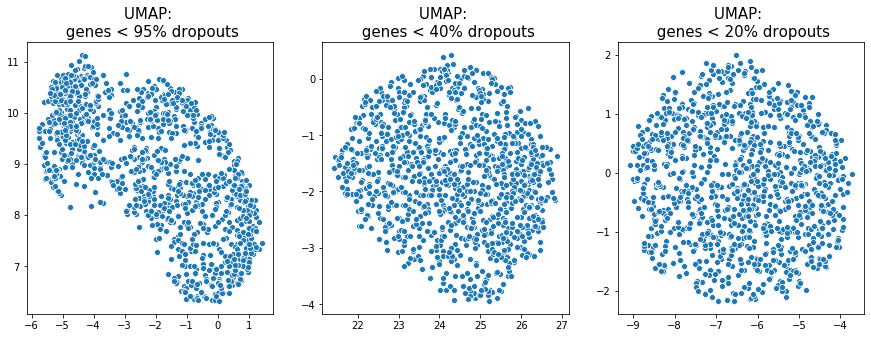

In [388]:
display(out.outputs[0])

In [389]:
%%capture out
# Compare dimension reductions with cell type overlays
fig = plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.scatterplot(pcafit95[:,0], pcafit95[:,1], hue = df2.index, legend = False)
plt.title('PCA: \n genes < 95% dropouts \n with cell type labels', size = 15)

plt.xlabel('PC2')
plt.ylabel('PC1')


plt.subplot(1,2,2)
sns.scatterplot(umap_results95[:,0], umap_results95[:,1], hue = df2.index)
plt.title('UMAP: \n genes < 95% dropouts \n with cell type labels', size = 15)
plt.legend(loc='center left', bbox_to_anchor=(1, .5),fontsize=10, 
           frameon = True, facecolor = 'white', framealpha=1, edgecolor = 'white')

plt.show()


## PCA vs UMAP with cell type labels

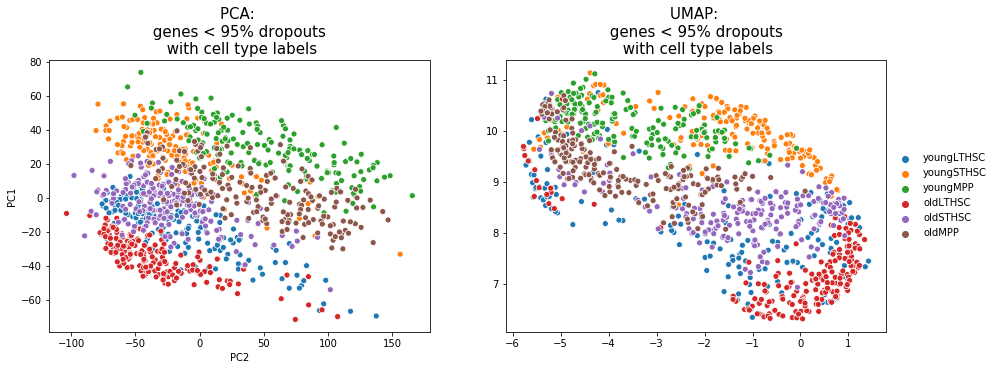

In [390]:
display(out.outputs[0])

In [391]:
%%capture out
#Visualize datasets with various dropout cutoffs by hierarchical clustering
fig = plt.figure(figsize = (15,4))
fig.subplots_adjust(hspace=1, wspace=.2)
plt.subplot(1,3,1)
dendrogram(linkage(df2_p95, method = 'ward'))
plt.title('H-clustering: \n genes < 95% dropouts', size = 14)
plt.subplot(1,3,2)
dendrogram(linkage(df2_p40, method = 'ward'))
plt.title('H-clustering: \n genes < 40% dropouts', size = 14)
plt.subplot(1,3,3)
dendrogram(linkage(df2_p20, method = 'ward'))
plt.title('H-clustering: \n genes < 20% dropouts', size = 14)
plt.show()

## Heirarchical clustering

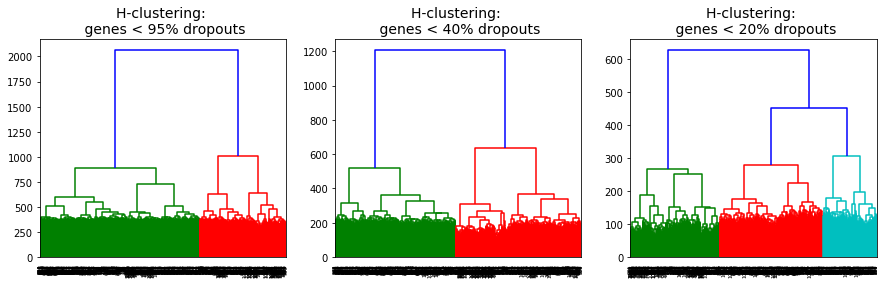

In [392]:
display(out.outputs[0])

### Second solution to zero-inflation:
##### perform dimension reduction by zero inflation factor analysis

"Factor analysis is a statistical method used to describe variability among observed, correlated variables in terms of a potentially lower number of unobserved variables called factors" Wikipedia

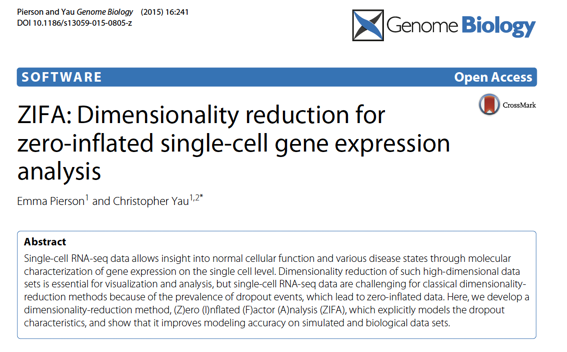




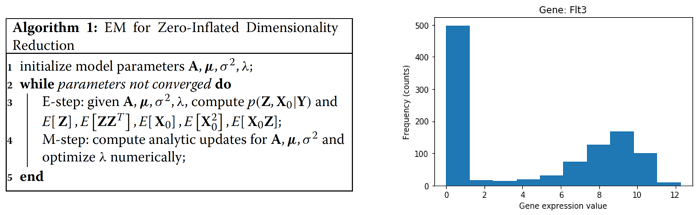

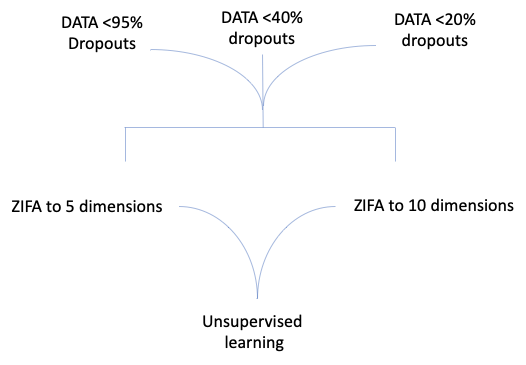

In [140]:
#Prepare dataset for ZIFA (convert to numpy array) for 95%, 40% and 20% dropout cutoff datasets (95% takes a while)
zifa_95 = df2[passindex95.index]
zifa_95 = np.round(zifa_95.astype(np.float64),4)
zifa_95 = np.array(zifa_95)


zifa_40 = df2[passindex40.index]
zifa_40 = np.round(zifa_40.astype(np.float64),4)
zifa_40 = np.array(zifa_40)

zifa_20 = df2[passindex20.index]
zifa_20 = np.round(zifa_20.astype(np.float64),4)
zifa_20 = np.array(zifa_20)



In [134]:

from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [141]:
start_time = time.time()
# Z95_5, model_params = block_ZIFA.fitModel(zifa_95, 5)
# Z95_10, model_params = block_ZIFA.fitModel(zifa_95, 10)
# Z40_5, model_params = block_ZIFA.fitModel(zifa_40, 5)
# Z40_10, model_params = block_ZIFA.fitModel(zifa_40, 10)
# Z20_5, model_params = block_ZIFA.fitModel(zifa_20, 5)
# Z20_10, model_params = block_ZIFA.fitModel(zifa_20, 10)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 16
Running block zero-inflated factor analysis with N = 1058, D = 8240, K = 5, n_blocks = 16
Block sizes [515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515]
Param change below threshold 1.000e-02 after 12 iterations
Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 16
Running block zero-inflated factor analysis with N = 1058, D = 8240, K = 10, n_blocks = 16
Block sizes [515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515, 515]
Param change below threshold 1.000e-02 after 12 iterations
--- 2217.0665259361267 seconds ---


In [143]:
# Generate dataframes from ZIFA transformed data
dfz5_95 = pd.DataFrame(Z95_5, index = df2.index)
dfz5_40 = pd.DataFrame(Z40_5, index = df2.index)
dfz5_20 = pd.DataFrame(Z20_5, index = df2.index)

dfz10_95 = pd.DataFrame(Z95_10, index = df2.index)
dfz10_40 = pd.DataFrame(Z40_10, index = df2.index)
dfz10_20 = pd.DataFrame(Z20_10, index = df2.index)


In [226]:
%%capture out
# Visulize the effect of ZIFA correcting zero inflation issue
fig = plt.figure(figsize = (15,5))
fig.subplots_adjust(hspace=.2, wspace=.2)

plt.subplot(131)
plt.hist(df2['Flt3'])
plt.title('No ZIFA < 95% dropouts')

plt.subplot(132)
plt.hist(dfz10_95[0])
plt.title('ZIFA to 10 dim < 95% dropouts')

plt.subplot(133)
plt.hist(dfz5_95[0])
plt.title('ZIFA to 5 dim < 95% dropouts')
plt.show()

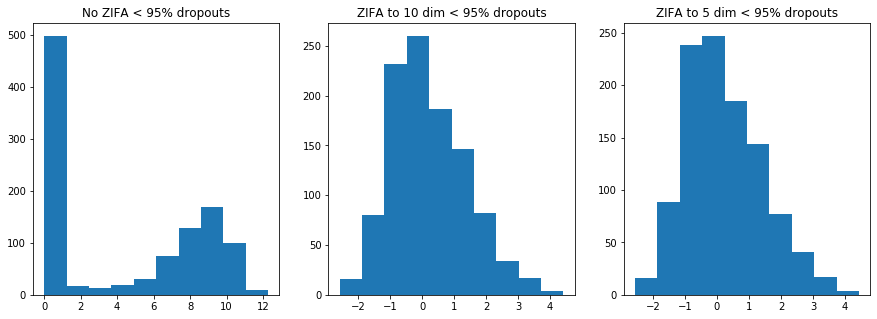

In [227]:
display(out.outputs[0])

In [144]:
# Apply dimension reduction on datasets with various dropout cutoffs
zumap5_95 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz5_95)
zumap5_40 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz5_40)
zumap5_20 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz5_20)


zumap10_95 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz10_95)
zumap10_40 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz10_40)
zumap10_20 = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz10_20)



In [156]:
%%capture out
# Visualize UMAP reduced data
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=.2, wspace=.2)
plt.subplot(231)
fig = sns.scatterplot(zumap5_95[:,0], zumap5_95[:,1])
fig.set_title('UMAP(z5_95): \n genes < 95% dropouts')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(232)
fig = sns.scatterplot(zumap5_40[:,0], zumap5_40[:,1])
fig.set_title('UMAP(z5_40): \n genes < 40% dropouts')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(233)
fig = sns.scatterplot(zumap5_20[:,0], zumap5_20[:,1])
fig.set_title('UMAP(z5_20): \n genes < 20% dropouts')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(234)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1])
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(235)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1])
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(236)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1])
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

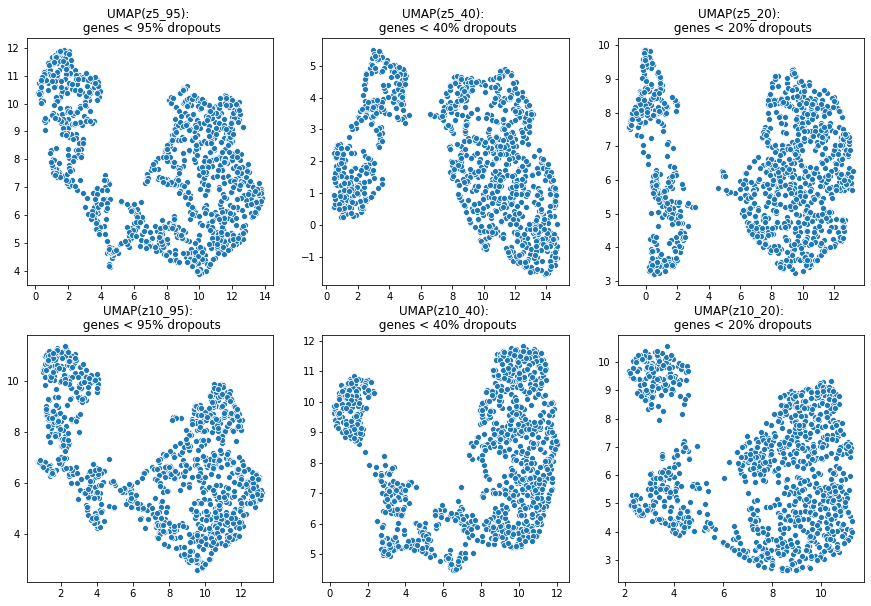

In [157]:
display(out.outputs[0])

In [162]:
%%capture out
# Visualize UMAP reduced data with cell type labels overlayed
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=.2, wspace=.2)
plt.subplot(231)
fig = sns.scatterplot(zumap5_95[:,0], zumap5_95[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z5_95): \n genes < 95% dropouts')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(232)
fig = sns.scatterplot(zumap5_40[:,0], zumap5_40[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z5_40): \n genes < 40% dropouts')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(233)
fig = sns.scatterplot(zumap5_20[:,0], zumap5_20[:,1], hue = df2.index)
fig.set_title('UMAP(z5_20): \n genes < 20% dropouts')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(234)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(235)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(236)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = df2.index)
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

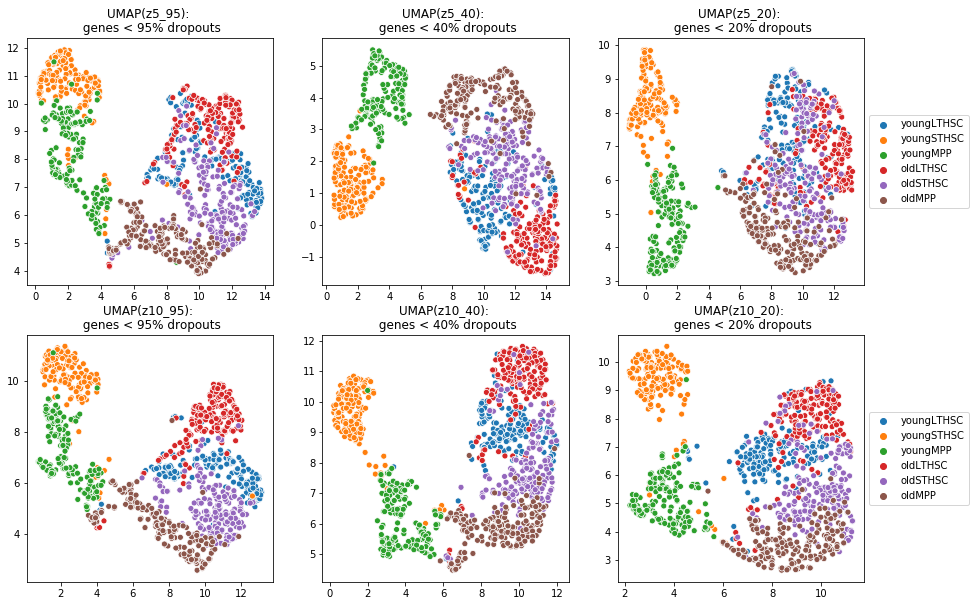

In [163]:
display(out.outputs[0])

In [166]:
# Generate cluster labels for ZIFA data
gmm10_95 = GaussianMixture(n_components = 6)
gmm10_95.fit(dfz10_95)
cluster10_95 = gmm10_95.fit_predict(dfz10_95)

gmm10_40 = GaussianMixture(n_components = 6)
gmm10_40.fit(dfz10_40)
cluster10_40 = gmm10_40.fit_predict(dfz10_40)

gmm10_20 = GaussianMixture(n_components = 6)
gmm10_20.fit(dfz10_20)
cluster10_20 = gmm10_20.fit_predict(dfz10_20)


In [177]:
%%capture out
# Visualize UMAP data and compare GMM and cell type labels overlayed
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=.5, wspace=.2)
plt.subplot(231)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = cluster10_95, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n GMM labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(232)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = cluster10_40, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n GMM labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(233)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = cluster10_20, palette =['b', 'r', 'g', 'm', 'y', 'c'], legend = 'full')
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n GMM labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(234)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(235)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(236)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = df2.index)
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

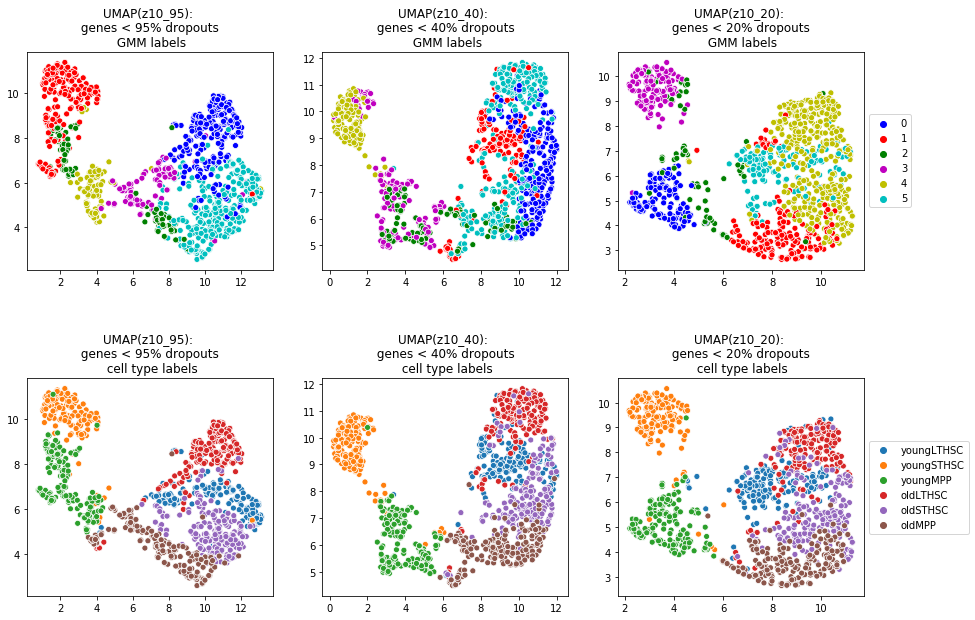

In [178]:
display(out.outputs[0])

In [180]:
# Generate cluster labels for ZIFA data
km10_95 = KMeans(n_clusters = 6, random_state=42)
km10_95.fit_transform(dfz10_95)
kpred10_95 = km10_95.fit_predict(dfz10_95)

km10_40 = KMeans(n_clusters = 6, random_state=42)
km10_40.fit_transform(dfz10_40)
kpred10_40 = km10_40.fit_predict(dfz10_40)

km10_20 = KMeans(n_clusters = 6, random_state=42)
km10_20.fit_transform(dfz10_20)
kpred10_20 = km10_20.fit_predict(dfz10_20)





In [184]:
%%capture out
# Visualize UMAP data and compare K-means and cell type labels overlayed
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=.5, wspace=.2)
plt.subplot(231)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = kpred10_95, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n Kmeans labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(232)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = kpred10_40, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n Kmeans labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(233)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = kpred10_20, palette =['b', 'r', 'g', 'm', 'y', 'c'], legend = 'full')
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n Kmeans labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(234)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(235)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(236)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = df2.index)
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

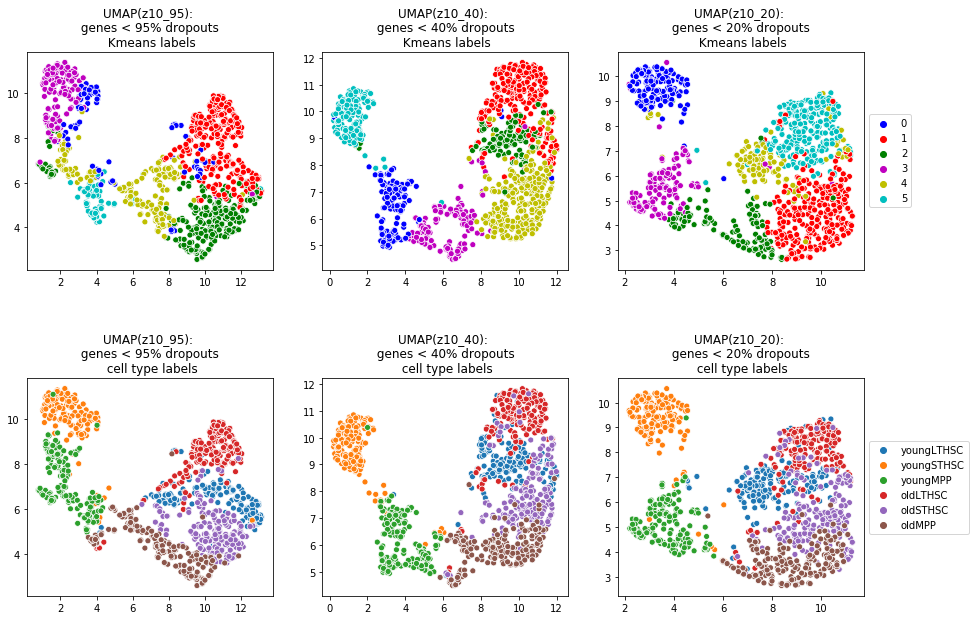

In [185]:
display(out.outputs[0])

In [188]:
# Generate cluster labels for ZIFA data
agg10_95 = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
agg10_95.fit(dfz10_95)
aggpred10_95 = agg10_95.fit_predict(dfz10_95)

agg10_40 = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
agg10_40.fit(dfz10_40)
aggpred10_40 = agg10_40.fit_predict(dfz10_40)

agg10_20 = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
agg10_20.fit(dfz10_20)
aggpred10_20 = agg10_20.fit_predict(dfz10_20)


In [191]:
%%capture out
# Visualize UMAP data and compare HA and cell type labels overlayed
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=.5, wspace=.2)
plt.subplot(231)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = aggpred10_95, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n Hierarchical cluster labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(232)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = aggpred10_40, palette =['b', 'r', 'g', 'm', 'y', 'c'],legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n Hierarchical cluster labels')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(233)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = aggpred10_20, palette =['b', 'r', 'g', 'm', 'y', 'c'], legend = 'full')
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n Hierarchical cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(234)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(235)
fig = sns.scatterplot(zumap10_40[:,0], zumap10_40[:,1], hue = df2.index, legend = False)
fig.set_title('UMAP(z10_40): \n genes < 40% dropouts \n cell type labels')
# #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(236)
fig = sns.scatterplot(zumap10_20[:,0], zumap10_20[:,1], hue = df2.index)
fig.set_title('UMAP(z10_20): \n genes < 20% dropouts \n cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

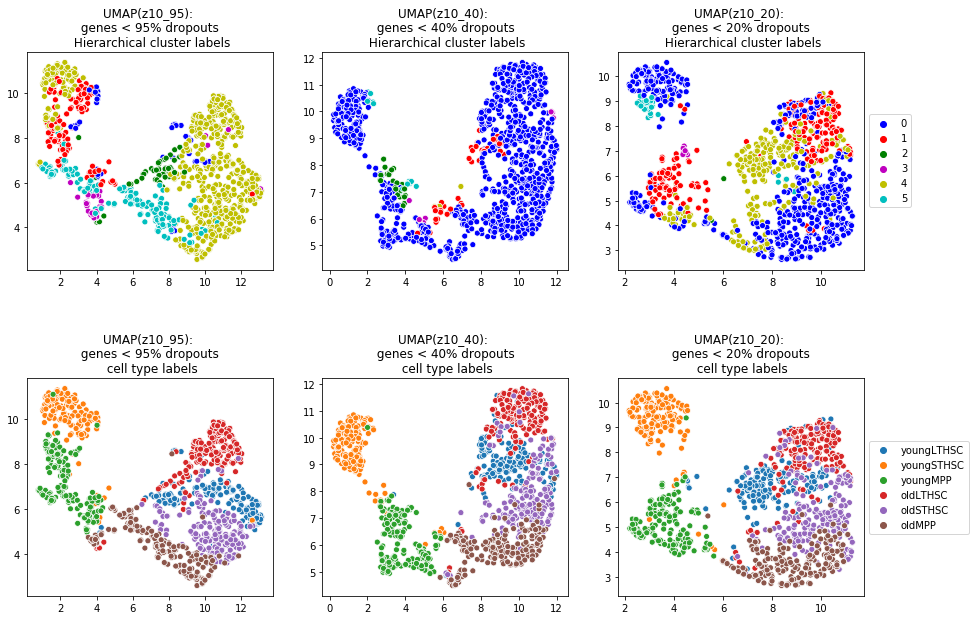

In [192]:
display(out.outputs[0])

In [207]:
# Generate cluster labels for UMAP components
zumap10_95km = KMeans(n_clusters = 6, random_state=42)
zumap10_95kmdata = zumap10_95km.fit_transform(zumap10_95)
zumap10_95kpred = zumap10_95km.fit_predict(zumap10_95)

zumap10_95agg = AgglomerativeClustering(n_clusters = 6, affinity='euclidean',linkage = 'complete')
zumap10_95aggdata = zumap10_95agg.fit(zumap10_95)
zumap10_95aggpred = zumap10_95aggdata.labels_

zumap10_95gmm = GaussianMixture(n_components = 6)
zumap10_95gmm.fit(zumap10_95)
zumap10_95gmmpred = zumap10_95gmm.fit_predict(zumap10_95)

In [369]:
%%capture out
# Visualize UMAP data and compare GMM(UMAP) and cell type labels overlayed
fig = plt.figure(figsize = (12,10))
fig.subplots_adjust(hspace=.3, wspace=.5)
plt.subplot(221)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1],zumap10_95gmmpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('UMAP(z10_95)-GMM: \n genes < 95% dropouts \n GMM(UMAP) labels', size = 10)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(222)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1],zumap10_95kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('UMAP(z10_95)-Kmeans: \n genes < 95% dropouts \n Kmeans(UMAP) labels', size = 10)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(223)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1],zumap10_95aggpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('UMAP(z10_95)-HC: \n genes < 95% dropouts \n Hierarchical(UMAP) labels', size = 10)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(224)
fig = sns.scatterplot(zumap10_95[:,0], zumap10_95[:,1], hue = df2.index)
fig.set_title('UMAP(z10_95): \n genes < 95% dropouts \n cell type labels', size = 10)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

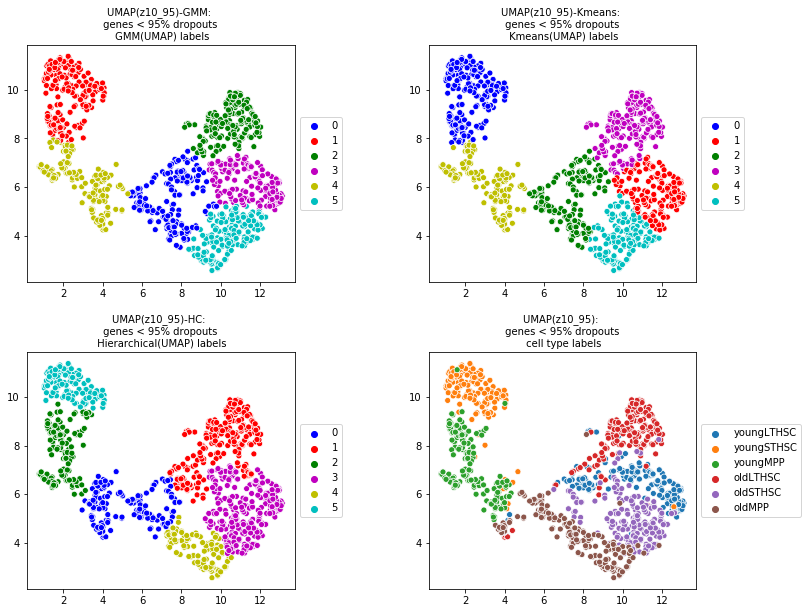

In [370]:
display(out.outputs[0])

In [343]:
%%capture out
# Plot ZIFA by dendogram view of hierarchical clustering
fig = plt.figure(figsize = (15,4))
fig.subplots_adjust(hspace=1, wspace=.2)
plt.subplot(1,3,1)
dendrogram(linkage(zumap10_95, method = 'ward'))
plt.title('H-clustering: \n genes < 95% dropouts', size = 14)
plt.subplot(1,3,2)
dendrogram(linkage(zumap10_40, method = 'ward'))
plt.title('H-clustering: \n genes < 40% dropouts', size = 14)
plt.subplot(1,3,3)
dendrogram(linkage(zumap10_20, method = 'ward'))
plt.title('H-clustering: \n genes < 20% dropouts', size = 14)
plt.show()

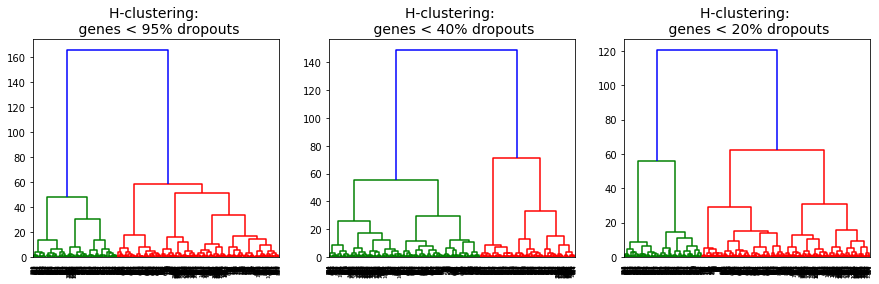

In [344]:
display(out.outputs[0])

In [296]:
# Create dataframe with stat descriptions of untransformed data
dfdes = df2.replace(0, np.nan).describe().T


In [316]:
# Make datasets from selected list of high and low variance genes preZIFA
varcolsHV = dfdes[dfdes['std']/dfdes['mean']>1].index
dfvarHV = df2[varcolsHV]

varcolsLV = dfdes[dfdes['std']/dfdes['mean']<.2].index
dfvarLV = df2[varcolsLV]
dfvarHV.shape

(1058, 59)

In [317]:
# Decide on allowed dropout rate
genefracs = (dfvarHV==0).sum()/(dfvarHV==0).count()
passindexHV = genefracs[genefracs < .95]

genefracs = (dfvarLV==0).sum()/(dfvarLV==0).count()
passindexLV = genefracs[genefracs < .95]
passindexHV.shape

(57,)

In [318]:
# Generate high and low variance arrays to by used for ZIFA transformation--needs to all by numpy floats
zifavarHV = dfvarHV[passindexHV.index].replace(np.nan, 0)
zifavarHV = np.round(zifavarHV.astype(np.float64),4)
zifavarHV = np.array(zifavarHV)

zifavarLV = dfvarLV[passindexLV.index].replace(np.nan, 0)
zifavarLV = np.round(zifavarLV.astype(np.float64),4)
zifavarLV = np.array(zifavarLV)

In [319]:
# Run ZIFA transformation
start_time = time.time()
ZHV, model_params = block_ZIFA.fitModel(zifavarHV,5)

ZLV, model_params = block_ZIFA.fitModel(zifavarLV,5)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1058, D = 57, K = 5, n_blocks = 1
Block sizes [57]
Param change below threshold 1.000e-02 after 17 iterations
Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1058, D = 634, K = 5, n_blocks = 1
Block sizes [634]
Param change below threshold 1.000e-02 after 13 iterations
--- 96.14317107200623 seconds ---


In [320]:
#Refit ZIFA data run on preselected 'high variance genes' 
zumapHV = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfvarHV)

kmHV = KMeans(n_clusters = 6, random_state=42)
kmdataHV = kmHV.fit_transform(dfvarHV)
kpredHV = kmHV.fit_predict(dfvarHV)

gmmHV = GaussianMixture(n_components = 6)
gmmHV.fit(dfvarHV)
clusterHV = gmmHV.fit_predict(dfvarHV)

In [377]:
%%capture out
#Show UMAP visualization of high variance gene ZIFA data
fig = plt.figure(figsize = (15,4))
fig.subplots_adjust(hspace=1, wspace=.6)
plt.subplot(131)
fig = sns.scatterplot(zumapHV[:,0], zumapHV[:,1], hue = df2.index)
fig.set_title('UMAP (5 dim): high variance genes \n cell type labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(132)
fig = sns.scatterplot(zumapHV[:,0], zumapHV[:,1], hue = clusterHV, palette = ['r', 'b', 'g', 'y', 'c', 'm'])
fig.set_title('UMAP (5 dim): high variance genes \n GMM cluster labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(133)
fig = sns.scatterplot(zumapHV[:,0], zumapHV[:,1], hue = kpredHV, palette = ['r', 'b', 'g', 'y', 'c', 'm'])
fig.set_title('UMAP (5 dim): high variance genes \n k-means labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

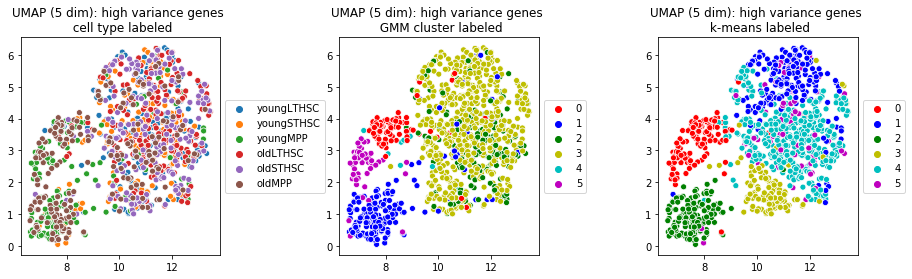

In [378]:
display(out.outputs[0])

In [323]:
#Refit ZIFA data run on preselected 'low variance genes' 
zumapLV = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfvarLV)

kmLV = KMeans(n_clusters = 6, random_state=42)
kmdataLV = kmLV.fit_transform(dfvarLV)
kpredLV = kmLV.fit_predict(dfvarLV)

gmmLV = GaussianMixture(n_components = 6)
gmmLV.fit(dfvarLV)
clusterLV = gmmLV.fit_predict(dfvarLV)

In [383]:
%%capture out
#Show UMAP visualization of low variance gene ZIFA data
fig = plt.figure(figsize = (15,4))
fig.subplots_adjust(hspace=.5, wspace=.6)
plt.subplot(131)
fig = sns.scatterplot(zumapLV[:,0], zumapLV[:,1], hue = df2.index)
fig.set_title('UMAP (5 dim): low variance genes \n cell type labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(132)
fig = sns.scatterplot(zumapLV[:,0], zumapLV[:,1], hue = clusterLV, palette = ['r', 'b', 'g', 'y', 'c', 'm'])
fig.set_title('UMAP (5 dim): low variance genes \n GMM cluster labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplot(133)
fig = sns.scatterplot(zumapLV[:,0], zumapLV[:,1], hue = kpredLV, palette = ['r', 'b', 'g', 'y', 'c', 'm'])
fig.set_title('UMAP (5 dim): low variance genes \n k-means labeled')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

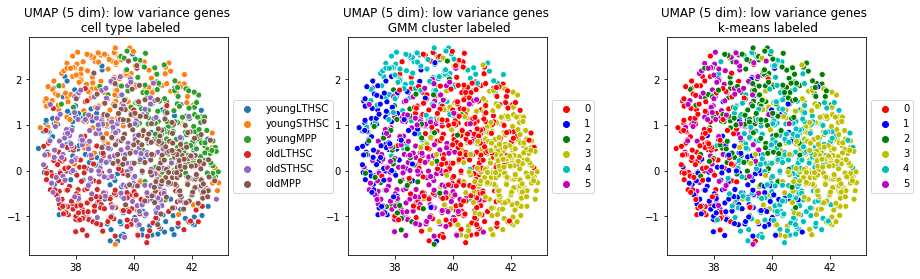

In [384]:
display(out.outputs[0])

# Summary:

1. ZIFA is important transformation that helps deal with dropout event issues associated with single cell gene analysis

2. There are interesting unexplored relationships between early stem cells that form the blood system              throughout life

3. Different clustering methods show both similarities and differences in matching cell type labels by UMAP

4. High variance gene comparisons reveal new subtypes of cells that are fairly independent of stem cell           type

 